<a href="https://colab.research.google.com/github/nissrinayy/deeplearning/blob/main/Week3/CNN_%26_MLP_PyTorch_SVHN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CNN & MLP menggunakan PyTorch : SVHN Dataset🍿**

CNN dirancang khusus untuk menangani data berbentuk grid, seperti gambar.MLP menggunakan fungsi aktivasi seperti ReLU atau sigmoid untuk menangani non-linearitas.Cocok untuk data terstruktur seperti tabel dalam tugas regresi dan klasifikasi.

MLP : Setiap neuron di satu lapisan terhubung penuh ke semua neuron di lapisan berikutnya (Fully Connected Layer).

CNN : Menggunakan lapisan konvolusi untuk mengekstrak fitur dari gambar dengan filter (kernel).Memiliki pooling layer (misalnya MaxPooling) untuk mengurangi dimensi fitur dan mengurangi overfitting.







## Persiapan dan Instalasi🥨

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np


In [ ]:
# Cek apakah GPU tersedia
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# Data augmentation & Normalization
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

## Load Data📊

In [ ]:
# Load SVHN dataset
dataset = datasets.SVHN(root="./data", split='train', transform=transform, download=True)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])


In [ ]:
test_dataset = datasets.SVHN(root="./data", split='test', transform=transform, download=True)


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

## Definisi Model🔖

In [ ]:
# Define CNN model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, 10)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(3 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
# Training function
def train_model(model, train_loader, val_loader, epochs=15, lr=0.001):
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(epochs):
        model.train()
        total_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        scheduler.step()

        # Validasi
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_acc = val_correct / val_total
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}, Val Acc: {val_acc:.4f}")


## Train & Evaluate Model 🍳

In [ ]:
# Train and evaluate CNN
cnn = CNN()
train_model(cnn, train_loader, val_loader, epochs=15)
cnn_acc, cnn_prec, cnn_rec, cnn_f1 = evaluate(cnn, test_loader)
print(f"CNN Testing: Acc={cnn_acc:.4f}, Precision={cnn_prec:.4f}, Recall={cnn_rec:.4f}, F1={cnn_f1:.4f}")


Epoch 1, Loss: 601.2580, Val Acc: 0.7295
Epoch 2, Loss: 365.7957, Val Acc: 0.7547
Epoch 3, Loss: 326.6537, Val Acc: 0.7787
Epoch 4, Loss: 304.1217, Val Acc: 0.7978
Epoch 5, Loss: 290.7617, Val Acc: 0.8008
Epoch 6, Loss: 263.0017, Val Acc: 0.8166
Epoch 7, Loss: 254.3209, Val Acc: 0.8243
Epoch 8, Loss: 249.0985, Val Acc: 0.8252
Epoch 9, Loss: 243.6646, Val Acc: 0.8308
Epoch 10, Loss: 236.3041, Val Acc: 0.8330
Epoch 11, Loss: 223.9405, Val Acc: 0.8410
Epoch 12, Loss: 220.2545, Val Acc: 0.8412
Epoch 13, Loss: 216.3633, Val Acc: 0.8425
Epoch 14, Loss: 216.2860, Val Acc: 0.8444
Epoch 15, Loss: 211.7007, Val Acc: 0.8472
CNN Testing: Acc=0.8219, Precision=0.8126, Recall=0.8034, F1=0.8070


In [ ]:
# Train and evaluate MLP
mlp = MLP()
train_model(mlp, train_loader, val_loader, epochs=15)
mlp_acc, mlp_prec, mlp_rec, mlp_f1 = evaluate(mlp, test_loader)
print(f"MLP Testing: Acc={mlp_acc:.4f}, Precision={mlp_prec:.4f}, Recall={mlp_rec:.4f}, F1={mlp_f1:.4f}")


Epoch 1, Loss: 763.7311, Val Acc: 0.5756
Epoch 2, Loss: 584.0711, Val Acc: 0.6392
Epoch 3, Loss: 522.1477, Val Acc: 0.6747
Epoch 4, Loss: 484.2901, Val Acc: 0.7013
Epoch 5, Loss: 457.7820, Val Acc: 0.7098
Epoch 6, Loss: 405.1418, Val Acc: 0.7480
Epoch 7, Loss: 389.5087, Val Acc: 0.7525
Epoch 8, Loss: 380.2957, Val Acc: 0.7608
Epoch 9, Loss: 373.8652, Val Acc: 0.7654
Epoch 10, Loss: 365.9130, Val Acc: 0.7619
Epoch 11, Loss: 341.8570, Val Acc: 0.7788
Epoch 12, Loss: 333.5517, Val Acc: 0.7818
Epoch 13, Loss: 330.4013, Val Acc: 0.7836
Epoch 14, Loss: 326.6624, Val Acc: 0.7878
Epoch 15, Loss: 322.6998, Val Acc: 0.7899
MLP Testing: Acc=0.7548, Precision=0.7467, Recall=0.7311, F1=0.7364


## Visualisasi 🔎

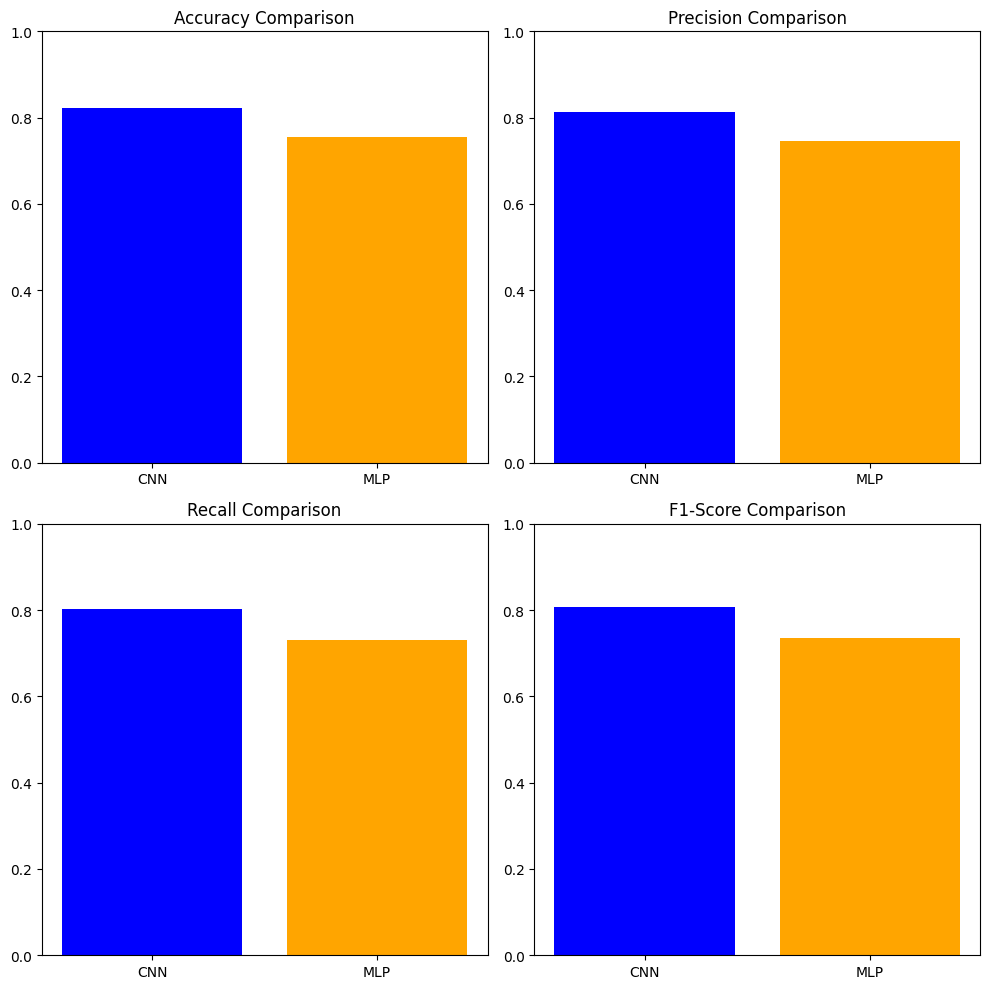

In [ ]:
import matplotlib.pyplot as plt

# Data untuk perbandingan model
models = ["CNN", "MLP"]
accuracies = [cnn_acc, mlp_acc]
precisions = [cnn_prec, mlp_prec]
recalls = [cnn_rec, mlp_rec]
f1_scores = [cnn_f1, mlp_f1]

# Membuat bar chart
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

axs[0, 0].bar(models, accuracies, color=['blue', 'orange'])
axs[0, 0].set_title('Accuracy Comparison')
axs[0, 0].set_ylim(0, 1)

axs[0, 1].bar(models, precisions, color=['blue', 'orange'])
axs[0, 1].set_title('Precision Comparison')
axs[0, 1].set_ylim(0, 1)

axs[1, 0].bar(models, recalls, color=['blue', 'orange'])
axs[1, 0].set_title('Recall Comparison')
axs[1, 0].set_ylim(0, 1)

axs[1, 1].bar(models, f1_scores, color=['blue', 'orange'])
axs[1, 1].set_title('F1-Score Comparison')
axs[1, 1].set_ylim(0, 1)

plt.tight_layout()
plt.show()


#**Penjelasan Singkat**

1️⃣ Akurasi (Accuracy)

Akurasi mengukur seberapa banyak prediksi yang benar dibandingkan dengan total prediksi.


Akurasi=

*TP+TN/
TP+TN+FP+FN*
​

📌 Keterangan:

TP (True Positive) → Prediksi benar sebagai positif.

TN (True Negative) → Prediksi benar sebagai negatif.

FP (False Positive) → Prediksi salah sebagai positif.

FN (False Negative) → Prediksi salah sebagai negatif.


2️⃣ Presisi (Precision)

Presisi mengukur seberapa akurat model dalam memprediksi kelas positif.

Presisi=
*TP/
TP+FP*



📌 Keterangan:

Jika model memiliki presisi tinggi, berarti model jarang salah dalam memprediksi kelas positif.

Jika presisi rendah, model sering salah memprediksi negatif sebagai positif (False Positive tinggi).

3️⃣ Recall (Sensitivitas)

Recall mengukur seberapa baik model dalam menangkap semua kasus positif.

Recall=
*TP/
TP+FN*


📌 Keterangan:

Jika recall tinggi, berarti model berhasil menangkap hampir semua data positif.
Jika recall rendah, model sering gagal mengenali positif sebagai negatif (False Negative tinggi).

4️⃣ F1-Score (Harmonic Mean)
F1-score menggabungkan presisi dan recall dalam satu metrik menggunakan rata-rata harmonik.

𝐹
1
=
2
×
Presisi
×
Recall/
Presisi
+
Recall

📌 Keterangan:

F1-score tinggi berarti model seimbang dalam presisi dan recall.

Bagus untuk dataset tidak seimbang, karena mempertimbangkan False Positive dan False Negative secara bersamaan.

5️⃣ Area Under Curve (AUC - ROC)
AUC (Area Under Curve) mengukur seberapa baik model membedakan antara kelas positif dan negatif.

AUC berasal dari ROC Curve, yang membandingkan True Positive Rate (TPR) vs False Positive Rate (FPR).

TPR
=
𝑇
𝑃/
𝑇
𝑃
+
𝐹
𝑁

(Sama dengan Recall)

*FPR=
FP/
FP+TN*

📌 Keterangan:

AUC = 1.0 → Model sempurna (memisahkan kelas dengan sempurna).
AUC = 0.5 → Model acak (tidak lebih baik dari tebak-tebakan).
AUC < 0.5 → Model lebih buruk dari acak (terbalik).

6️⃣ Receiver Operating Characteristic (ROC) Curve

ROC Curve adalah grafik yang membandingkan TPR vs FPR pada berbagai threshold.


Sumbu X → FPR (False Positive Rate)

Sumbu Y → TPR (True Positive Rate / Recall)

📌 Bagaimana membacanya?


Semakin tinggi kurva, semakin baik model.

ROC yang mendekati diagonal (AUC ≈ 0.5) berarti model tidak berguna.